# Jupyter notebook based on ImageD11 to process 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 13/02/2024

This notebook will help you to extract the locations of diffraction peaks on your detector images.

It will also merge together your 2D spots (on a stack of detector images with different omega angles).

We merge across omega because we often see the same spot twice on multiple detector images.

The results are saved to the PROCESSED_DATA folder of the experiment, inside the sample and dataset folders that you select within this notebook

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import glob, pprint

import ImageD11.sinograms.dataset
import ImageD11.sinograms.lima_segmenter
import ImageD11.sinograms.assemble_label
import ImageD11.sinograms.properties

import numpy as np
import fabio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage import filters, measure, morphology
import ipywidgets as widgets
import h5py
from IPython.display import display
%matplotlib widget


from frelon_peaksearch import worker, process

from utils import apply_spatial

In [3]:
# Check that we're importing ImageD11 from the home directory rather than from the Jupyter kernel

?ImageD11.sinograms.dataset

Type:        module
String form: <module 'ImageD11.sinograms.dataset' from '/home/esrf/james1997a/Code/ImageD11/ImageD11/sinograms/dataset.py'>
File:        ~/Code/ImageD11/ImageD11/sinograms/dataset.py
Docstring:   <no docstring>

In [3]:
# NEW DATASETS

### USER: specify your experimental directory

base_dir = "/data/visitor/ma5837/id11/20240208"

rawdata_path = os.path.join(base_dir, 'RAW_DATA')

!ls -lrt {rawdata_path}

processed_data_root_dir = os.path.join(base_dir, 'PROCESSED_DATA')  # USER: modify this to change the destination folder if desired

total 2941
drwxr-x---  3 opid11 id11    4096 Feb  7 13:36 nanox_test
drwxr-x---  3 opid11 id11    4096 Feb  7 17:05 nanox_test_02_HC
drwxr-x---  3 opid11 id11    4096 Feb  7 17:34 nanox_test_no_sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:25 sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:26 test_stress_session
drwxr-x---  3 opid11 id11    4096 Feb  8 09:26 S06
drwxr-x--- 16 opid11 id11    4096 Feb  8 14:57 S20
drwxr-x---  3 opid11 id11    4096 Feb  8 16:26 S11
drwxr-x---  3 opid11 id11    4096 Feb  8 17:17 S05
drwxr-x--- 20 opid11 id11    4096 Feb  8 21:18 S20_HC1
drwxr-x--- 13 opid11 id11    4096 Feb  9 08:38 S18
drwxr-x---  3 opid11 id11    4096 Feb  9 10:14 empty_no_sample
drwxr-x--- 12 opid11 id11    4096 Feb  9 10:54 S17
drwxr-x--- 12 opid11 id11    4096 Feb  9 12:34 S16
drwxr-x---  2 opid11 id11    4096 Feb  9 13:59 test_fatigue_curvesave
drwxr-x---  2 opid11 id11    4096 Feb  9 14:11 S18_HC_fatigue_plots
drwxr-x---  2 opid11 id11    4096 Feb  9 14:47 S17_fatigue_plots


In [5]:
# USER: pick a sample and a dataset you want to segment

sample = "S12"
dataset = "FF_zeries_0"

# USER: specify path to detector mask

mask_path = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/mask.edf'

In [6]:
# create ImageD11 dataset object

ds = ImageD11.sinograms.dataset.DataSet(dataroot=rawdata_path,
                                        analysisroot=processed_data_root_dir,
                                        sample=sample,
                                        dset=dataset,
                                        detector="frelon3",
                                        omegamotor="diffrz",
                                        dtymotor="diffty")
ds.import_all(scans=["1.1"])
ds.save()

Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG


In [7]:
bg_path = os.path.join(ds.analysisroot, "CeO2/CeO2_bkg_3dxrd_beam_shutter_open/CeO2_bkg_3dxrd_beam_shutter_open.edf")
bg_path

'/data/visitor/ma5837/id11/20240208/PROCESSED_DATA/CeO2/CeO2_bkg_3dxrd_beam_shutter_open/CeO2_bkg_3dxrd_beam_shutter_open.edf'

In [8]:
with h5py.File(ds.masterfile, 'r') as h5In:
    test_image = h5In['1.1/measurement/frelon3'][0].astype('uint16')

In [9]:
test_image_worker = worker(bgfile=bg_path)
goodpeaks = test_image_worker.peaksearch(img=test_image, omega=0)
fc, sc = goodpeaks[:, 23:25].T

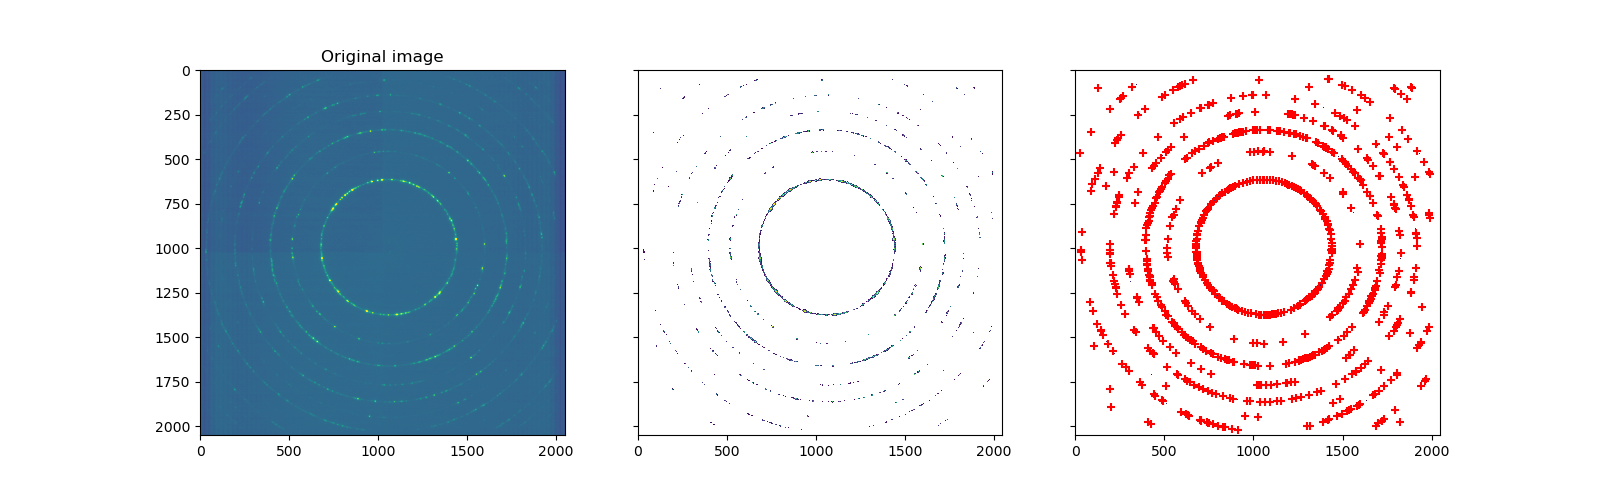

In [10]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 5))
axs[0].imshow(test_image, norm=LogNorm(vmax=1000))
axs[0].set_title("Original image")
axs[1].imshow(test_image_worker.smoothed, cmap="viridis", norm=LogNorm(vmax=1000), interpolation="nearest")
axs[2].imshow(test_image_worker.smoothed, cmap="viridis", norm=LogNorm(vmax=1000), interpolation="nearest")
axs[2].scatter(fc, sc, marker='+', c="r")
axs[2].set_aspect(1)
plt.show()

In [11]:
# now we run the segmenter on all our data

cf_2d, cf_3d = process(ds, bg_path, 64)

  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components


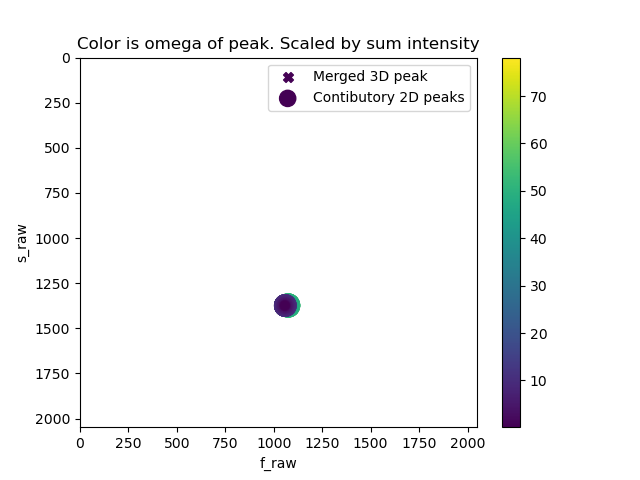

In [12]:
# we can use this to verify that the 3D merging is behaving as expected
# don't worry about this too much!

# take a few 3d peaks with the most 2d peaks, plot them

unique, counts = np.unique(cf_2d.spot3d_id, return_counts=True)
hits_dict = dict(zip(unique, counts))
hits_dict_max = sorted(hits_dict.items(), key=lambda x: x[1], reverse=True)

m = np.isin(cf_3d.index, [spot3d_id for spot3d_id, count in hits_dict_max[4:5]])
cf_3d_single_peak = cf_3d.copy()
cf_3d_single_peak.filter(m)

peak_2d_mask = np.isin(cf_2d.spot3d_id, cf_3d_single_peak.index)
cf_2d_peaks = cf_2d.copy()
cf_2d_peaks.filter(peak_2d_mask)

fig, ax = plt.subplots()
ax.scatter(cf_3d_single_peak.f_raw, cf_3d_single_peak.s_raw, marker="X", c=cf_3d_single_peak.omega, s=50, label='Merged 3D peak')
cols = ax.scatter(cf_2d_peaks.f_raw, cf_2d_peaks.s_raw, c=cf_2d_peaks.o_raw, s=cf_2d_peaks.s_I / 1000, label='Contibutory 2D peaks')
fig.colorbar(cols)
ax.set_xlim(0, 2048)
ax.set_ylim(0, 2048)
ax.invert_yaxis()
ax.legend()
ax.set_title("Color is omega of peak. Scaled by sum intensity")
ax.set_xlabel("f_raw")
ax.set_ylabel("s_raw")
plt.show()

In [13]:
spline_file = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/frelon36.spline'

In [14]:
cf_2d = apply_spatial(cf_2d, spline_file)

Spatial correction...


  0%|          | 0/1120332 [00:00<?, ?it/s]

In [15]:
cf_3d = apply_spatial(cf_3d, spline_file)

Spatial correction...


  0%|          | 0/506939 [00:00<?, ?it/s]

In [16]:
parfile = 'Fe_refined.par'

In [18]:
cf_2d.parameters.loadparameters(parfile)

cf_2d.updateGeometry()
ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

In [19]:
cf_3d.parameters.loadparameters(parfile)
cf_3d.updateGeometry()
ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile)

In [6]:
# Now that we're happy with our segmentation parameters, we can run the below cell to do this in bulk for many samples/datasets
# just modify samples_dict accordingly!

mask_path = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/mask.edf'

spline_file = '/data/id11/inhouse1/ewoks/detectors/files/Frelon2k_C36/frelon36.spline'
parfile = 'Fe_refined.par'

samples_dict = {
    "S13" : [
        "FF_zeries_0",
        "FF_zeries_1",
        "FF_zeries_2",
        "FF_zeries_3",
        "FF_zeries_4",
    ],
    "S14" : [
        "FF_zeries_0",
        "FF_zeries_1",
        "FF_zeries_2",
        "FF_zeries_3",
        "FF_zeries_4",
    ],
}

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        print("Importing DataSet object")
        ds = ImageD11.sinograms.dataset.DataSet(dataroot=rawdata_path,
                                            analysisroot=processed_data_root_dir,
                                            sample=sample,
                                            dset=dataset,
                                            detector="frelon3",
                                            omegamotor="diffrz",
                                            dtymotor="diffty")
        ds.import_all(scans=["1.1"])
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        ds.save()
        
        bg_path = os.path.join(ds.analysisroot, "CeO2/CeO2_bkg_3dxrd_beam_shutter_open/CeO2_bkg_3dxrd_beam_shutter_open.edf")
        
        print("Peaksearching")
        cf_2d, cf_3d = process(ds, bg_path, 64)
        
        print("Spatially correcting peaks")
        cf_2d = apply_spatial(cf_2d, spline_file)
        cf_3d = apply_spatial(cf_3d, spline_file)
        
        print("Saving peaks to file")
        cf_2d.parameters.loadparameters(parfile)

        cf_2d.updateGeometry()
        ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)
        
        cf_3d.parameters.loadparameters(parfile)
        cf_3d.updateGeometry()
        ImageD11.columnfile.colfile_to_hdf(cf_3d, ds.col3dfile)

Processing dataset FF_zeries_0 in sample S13
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_0 in sample S13
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1218372 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/542424 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_1 in sample S13
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_1 in sample S13
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1210394 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/542444 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_2 in sample S13
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_2 in sample S13
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1234312 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/560751 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_3 in sample S13
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_3 in sample S13
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1242790 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/573113 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_4 in sample S13
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_4 in sample S13
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1237050 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/564062 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_0 in sample S14
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_0 in sample S14
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1070228 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/486856 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_1 in sample S14
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_1 in sample S14
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1066180 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/482668 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_2 in sample S14
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_2 in sample S14
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1045910 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/476190 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_3 in sample S14
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_3 in sample S14
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1029741 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/471403 [00:00<?, ?it/s]

Saving peaks to file
Processing dataset FF_zeries_4 in sample S14
Importing DataSet object
Scan title finterlaced diffrz 0 0.25 0.08 1440 mode=ZIGZAG
I have a DataSet FF_zeries_4 in sample S14
Peaksearching


  0%|          | 0/1440 [00:00<?, ?it/s]

Making 3D merge
made trees
connected components
Spatially correcting peaks
Spatial correction...


  0%|          | 0/1033554 [00:00<?, ?it/s]

Spatial correction...


  0%|          | 0/468930 [00:00<?, ?it/s]

Saving peaks to file
